# Classes, objets et usages avancés

![logo python](fig/python-logo.png)

- Structurer un programme
- Notions de programmation objet
- Classes en Python
- Suite du micro-projet
- Usages avancés

***

*Contenu sous licence [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0), fortement inspiré de <https://fitzinger.gitlab.io/formation-python>*

## Structurer un programme

### Pourquoi faire ?

Le fichier [exos/meteo_json.py](exos/meteo_json.py) du micro-projet est un script linéaire qui n'est pas réutilisable directement depuis un autre programe.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Pour augmenter la résolution
%pycat exos/meteo_json.py

Si on veut le réutiliser, il faut le structurer en fonctions que l'on peut appeler depuis un programme principal.

Entrer la ville :
Strasbourg
Choisir le jour :
0) Mardi
1) Mercredi
2) Jeudi
3) Vendredi
4) Samedi
Samedi 
Entrée non valide.
Choisir le jour :
0) Mardi
1) Mercredi
2) Jeudi
3) Vendredi
4) Samedi
Jeudi
Entrée non valide.
Choisir le jour :
0) Mardi
1) Mercredi
2) Jeudi
3) Vendredi
4) Samedi
1


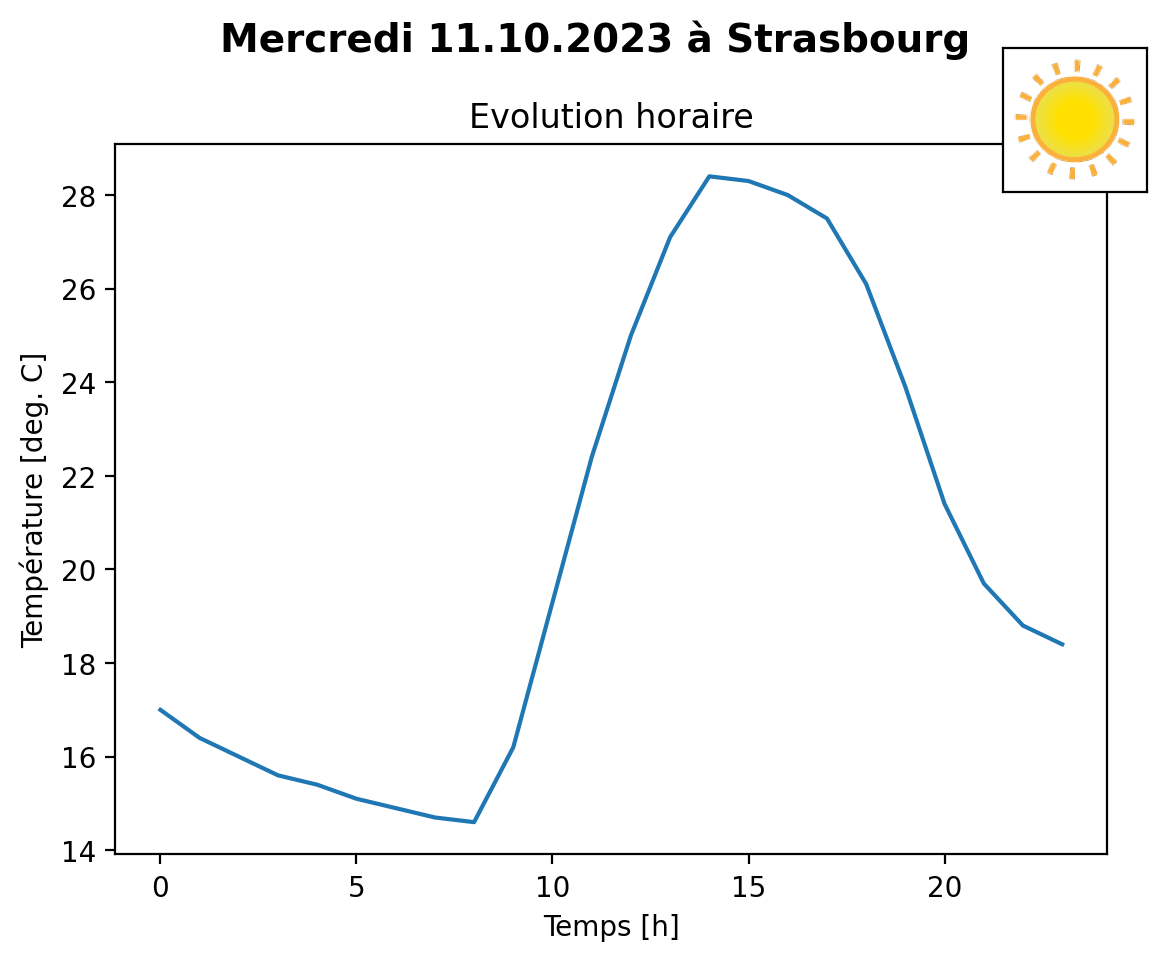

In [2]:
# %load exos/meteo_json_func.py
#!/usr/bin/env python3
"""
Process a weather forecast json file to plot the time evolution of temperature
of a given day in a given city
"""

import urllib.request
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import ssl
from io import BytesIO

context = ssl._create_unverified_context()


def get_json_from_name(city_name):
    jsonfile_url = "https://www.prevision-meteo.ch/services/json/"\
                   + city_name
    f = urllib.request.urlopen(jsonfile_url, context=context)  # open url
    return json.loads(f.read())


def get_city_from_user():
    """From user input, return a meteo json dictionary corresponding to city"""

    while True:  # Infinite loop to handle city name input
        city_name = input("Entrer la ville :\n")
        city_json = get_json_from_name(city_name)
        if 'errors' in city_json:
            print("{} n'existe pas dans la base. Essayez un autre nom."
                  .format(city_name))
        else:
            return city_json


def plot_day_tempe(city_json, day_key):
    """Plot Temperature vs hour from a json dictionary for a given day_key"""

    city_name = city_json['city_info']['name']
    day = city_json[day_key]
    day_hd = day['hourly_data']  # point to hourly data

    # Get tempe = [[h1, T1], [h2, T2], ...] list
    # where h1 is the time in hour and T2 is the temperature in deg. C
    tempe = []
    for hour, data in day_hd.items():
        # get first part of time in "00H00" format and remove "H00"
        # get temperature at 2m above ground 'TMP2m'
        tempe.append([int(hour[:-3]), data['TMP2m']])
    # Alternative form using list comprehension:
    # tempe = [[int(hour[:-3]), data['TMP2m']] for hour, data in day_hd.iteritems()]

    tempe.sort()  # Sort temperatures according to the hour of day
    t = np.array(tempe).transpose()  # Transpose list of (hour, tempe)

    # Plot T = T(hour)
    fig = plt.figure()  # initialise figure
    title = "{} {} à {}".format(day['day_long'], day['date'], city_name)
    fig.suptitle(title, fontsize=14, fontweight='bold')

    ax = fig.add_subplot(111)  # initialise a plot area
    fig.subplots_adjust(top=0.85)
    ax.set_title('Evolution horaire')
    ax.set_xlabel('Temps [h]')
    ax.set_ylabel('Température [deg. C]')

    ax.plot(t[0], t[1])  # plot t[1] (tempe) as a function of t[0] (hour)

    # Add meteo icon to plot
    # Open weather icon
    response = urllib.request.urlopen(day['icon_big'], context=context)
    icon = BytesIO(response.read())
    axicon = fig.add_axes([0.8, 0.8, 0.15, 0.15])
    img = mpimg.imread(icon)  # initialise image
    axicon.set_xticks([])  # Remove axes ticks
    axicon.set_yticks([])
    axicon.imshow(img)  # trigger the image show
    plt.show()  # trigger the figure show


def get_day(city_json):
    """From user input, return the day key in json dictonary"""

    days = {day: data['day_long'] for day, data in city_json.items()
            if day[:8] == "fcst_day"}  # Create {'fcst_day_#': week-day}
    question = "Choisir le jour :\n"
    days_list = []  # Build ['fcst_day_#', week-day] sorted list
    # This i-loop is required because "days" is not sorted:
    for i in range(5):
        key = "fcst_day_{}".format(i)
        days_list.append([key, days[key]])
        question = question + "{}) {}\n".format(i, days[key])
    while True:
        try:
            choice = int(input(question))  # Prompt user for day index
            return days_list[choice][0]  # Return 'fcst_day_#'
        except:
            print("Entrée non valide.")


if __name__ == '__main__':
    # This block is not executed if this file is imported as a module
    city_json = get_city_from_user()  # get json dict from user input
    day_key = get_day(city_json)  # get day key from user input
    plot_day_tempe(city_json, day_key)  # plot day temperature evolution


Si on définit une nouvelle fonction pour récupérer le dictionnaire de la ville :

In [3]:
import sys

def get_city(city_name):
    """return a meteo json dictionary corresponding to city_name"""

    jsonfile_url = "https://www.prevision-meteo.ch/services/json/"\
                   + city_name
    f = urllib.request.urlopen(jsonfile_url)  # open url
    city_json = json.load(f)
    if 'errors' in city_json:
        msg = "La ville n'est pas dans la base"
        sys.exit(msg)
    else:
        return city_json

On peut maintenant appeler les fonctions `get_city()` et `plot_day_tempe()` séparément du reste du script :

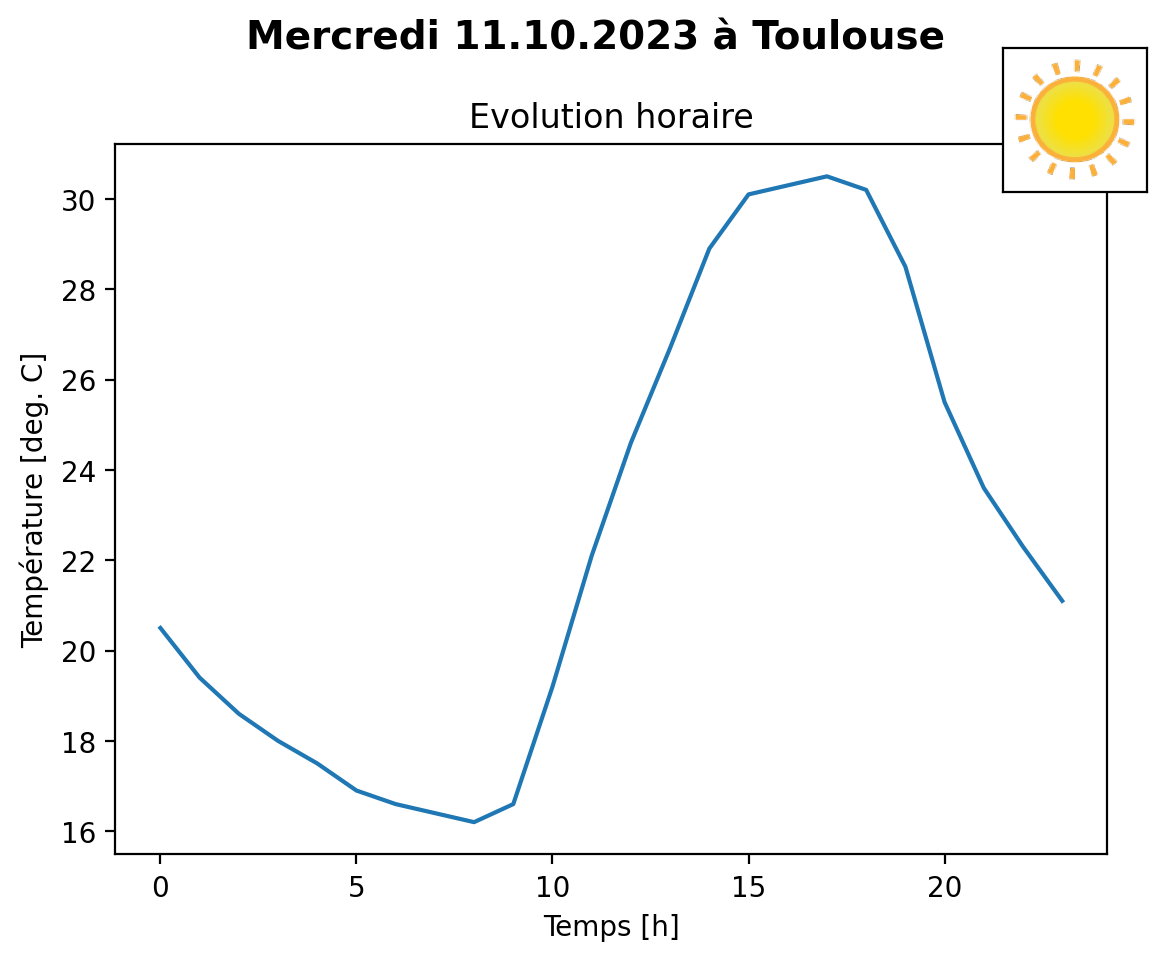

In [4]:
city_json = get_city("Toulouse")
plot_day_tempe(city_json, 'fcst_day_1') 

## Notions de programmation orientée objet

La [programmation orientée objet](https://fr.wikipedia.org/wiki/Programmation_orient%C3%A9e_objet) est un paradigme de programmation qui introduit en particulier les concepts suivants :

- encapsulation
- classes
- objets
- héritage

### Encapsulation

L'encapsulation est la manière d'associer les données et les méthodes qui s'y appliquent dans un même type appelé objet.

### Classes
    
- la classe est le code qui définit l'objet par ses attributs et ses méthodes
- les méthodes sont des fonctions qui agissent sur les attributs de l'objet.

### Objets

Les objets sont les instances de cette classe. Ils sont créés en *appelant* la classe comme on appelle une fonction :

```python
a = MaClasse(45, True, 'toto')
b = MaClasse(78, False, 'titi')
```

- L'objet **`a`** est une instance de la classe **`MaClasse`**.
- L'objet **`b`** est une autre instance de **`MaClasse`**.  
- `45, True, 'toto'` sont les arguments passés à l'initialiseur.

### Héritage

- l'héritage permet de créer des classes dérivées qui partagent du code et des données de leur(s) parent(s)
- les classes enfants héritent des attributs et des méthodes de leur(s) parent(s)
- Il est possible d'hériter de plusieurs classes. On parle alors d'héritage multiple.

L'héritage évite la duplication de code ! Le code commun se trouve en un seul exemplaire dans la ou les classes parentes.

## Classes en Python

### Définir une classe

Pour illustrer le mécanisme, on définit une classe appelée `Vecteur` de la façon suivante :

In [1]:
class Vecteur:
    commentaire = "Cette classe est top"

    def __init__(self, x, y, z):
        self.coord = [x, y, z]
        
print(Vecteur)

<class '__main__.Vecteur'>


### Instancier un objet

- Pour instancier une classe, on utilise la notation d'appel de fonction
- Cet appel renvoie une instance de la classe

In [2]:
v1 = Vecteur(1., 2., 3.)
v2 = Vecteur(0., 0., 0.)
print(type(v1))

<class '__main__.Vecteur'>


- `v1` et `v2` sont deux instances de la classe `Vecteur`
- `self` :
    - est le premier argument de toutes les fonctions de la classe
    - reçoit de manière automatique une référence à l'instance de l'objet
    - est nommé ainsi par convention
    - est omis lors de l'appel
    - dans la définition de la classe les attributs sont référencés par la notation `self.un_attribut`

- la méthode `__init__()`
    - c'est la méthode qui est appelée automatiquement lors de l'instanciation
    - elle est appelée *initialiseur*
    - elle reçoit les paramètres qui permettent l'initialisation de l'objet
- Ici, `commentaire` est un **attribut de la classe :** il ne dépend pas de son instanciation.

In [3]:
print(Vecteur.commentaire) 

Cette classe est top


- `self.coord` est un **attribut de l'objet** qui est construit lors de l'instanciation

In [4]:
print(v1.coord, v2.coord)
print('commentaire' in dir(Vecteur))  # Rappel : dir() renvoie la liste des attributs de l'objet
print('commentaire' in dir(v1))
print('coord' in dir(Vecteur))
print('coord' in dir(v1))

[1.0, 2.0, 3.0] [0.0, 0.0, 0.0]
True
True
False
True


### Surcharge d'opérateur

La surcharge d'opérateur consiste à redéfinir des fonctions existantes de la classe.

Par exemple, on souhaite représenter le contenu de l'objet en surchargeant la méthode `__repr__()`.
La fonction `print()` appliquée à l'instance fait un appel à `__repr__()`. Si `__repr__()` n'est pas définie dans la classe, `print` renvoie ce type de sortie :

In [5]:
v1 = Vecteur(1., 2., 3.)
print(v1)

Ce comportement de `__repr__()` correspond en réalité à la méthode de la classe de base dont hérite `Vecteur`.

On surcharge la méthode `__repr__()` en écrivant sa définition dans la classe :

In [6]:
class Vecteur:
    commentaire = "Cette classe est top"

    def __init__(self, x, y, z):
        self.coord = [x, y, z]

    def __repr__(self):
        """On surcharge l'opérateur __repr__ en renvoyant
        une chaîne de caractère"""
        return ''.join(f'({c})\n' for c in self.coord)


La fonction `print()` renvoie alors :

In [7]:
v1 = Vecteur(1., 2., 3.)
print(v1)

(1.0)
(2.0)
(3.0)



### Opérateurs arithmétiques

Les opérateurs arithmétiques sont définis si la méthode associée est implémentée. Par exemple, pour utiliser l'opérateur `+` entre deux objets, la classe doit définir la méthode `__add__()`.

In [18]:
def __add__(self, v):
    """
    self: l'instance de Vecteur comme membre de gauche de l'opérateur `+`
    v: un autre objet Vecteur comme membre de droite
    Retourne une nouvelle instance Vecteur correspondant à la somme vectorielle `self + v`
    """
    if len(self.coord) != len(v.coord):
        raise ValueError("Les vecteurs ont des tailles différentes.")
    
    result = [self.coord[i] + v.coord[i] for i in range(len(self.coord))]
    return Vecteur(*result)


On définit la fonction existante `__add__()` comme nouvelle méthode de `Vecteur` :

In [19]:
Vecteur.__add__ = __add__  # cette syntaxe est permise par le caractère dynamique de Python

On peut alors utiliser l'opérateur `+` :

In [20]:
v1 = Vecteur(1., 2., 3.)
v2 = Vecteur(3., 2., 1.)
print(v1 + v2)

(4.0)
(4.0)
(4.0)



**Exercice :** Implémenter la méthode `__mul__()` afin de définir le produit vectoriel entre

$$v_1 =
\begin{pmatrix}
x_1\\
y_1\\
z_1\\
\end{pmatrix}
\quad
\textrm{et}
\quad
v_2 =
\begin{pmatrix}
x_2\\
y_2\\
z_2\\
\end{pmatrix}
$$

Rappel : le produit vectoriel $v_1\wedge v_2$ s'écrit
$$
v_1\wedge v_2 = {
\begin{pmatrix}
y_{1}z_{2}-z_{1}y_{2}\\
z_{1}x_{2}-x_{1}z_{2}\\
x_{1}y_{2}-y_{1}x_{2}
\end{pmatrix}}
$$

In [21]:
def __mul__(self, v):
    """Retourne le produit vectoriel de self par v"""
    pass
    # votre code ici

Vecteur.__mul__ = __mul__

v1 = Vecteur(1., 0., 0.)
v2 = Vecteur(0., 1., 0.)
print(v1 * v2)

None


In [32]:
def __mul__(self, v):
    """Produit vectoriel"""
    x1, y1, z1 = self.coord
    x2, y2, z2 = v.coord
    xp = y1*z2 - z1*y2
    yp = z1*x2 - x1*z2
    zp = x1*y2 - y1*x2
    return Vecteur(xp, yp, zp)

Vecteur.__mul__ = __mul__

v1 = Vecteur(1., 0., 0.)
v2 = Vecteur(0., 1., 0.)
v1 * v2


(0.0)
(0.0)
(1.0)

### Héritage

Pour que la classe `Enfant` hérite des classes `Parent1` et `Parent2`, il faut passer ses dernières en arguments de la définition de `Enfant` :

```python
class Enfant(Parent1, Parent2):
    pass
```
> **Note :** En dehors de cet exemple, nous n'abordons pas ici les classes ayant plusieurs parents. Vous trouverez la documentation sur le sujet de l'héritage multiple dans ce [tutoriel](https://docs.python.org/3/tutorial/classes.html#inheritance).

#### Illustration du mécanisme d'héritage

Nous reprenons la classe `Vecteur` précédente dont nous dérivons la classe `Force` :

In [33]:
class Force(Vecteur):
    
    def __init__(self, x, y, z, x_a, y_a, z_a):
        """
        x_a, y_a, z_a: coordonnées du point d'application de la force
        """
        super().__init__(x, y, z)
        self.coord_app = [x_a, y_a, z_a]

    def __add__(self, v):
        # Appel de la méthode __add__ de la classe parente Vecteur
        return super().__add__(v)

    def __mul__(self, v):
        # Appel de la méthode __mul__ de la classe parente Vecteur
        return super().__mul__(v)

f = Force(1., 0., 0., 1., -1., 0.)
g = Force(1., 0., 0., 1., -1., 0.)
print(f*g)
#print(f.__repr__())

(0.0)
(0.0)
(0.0)



- En redéfinissant la fonction `__init__()`, nous *surchargeons* la méthode `__init__()` de la classe `Vecteur`.
- La fonction `super()` renvoie un objet qui permet d'accéder aux méthodes de la classe parente.

On dit que `Force` *hérite* de la classe `Vecteur`, ce qui signifie que toutes les méthodes définies dans `Vecteur` sont définies dans `Force` :

In [91]:
print(f + g)
print(f * g)

AttributeError: 'super' object has no attribute '__add__'

On voit ici que `Force` a hérité de `__repr__()`, `__add__()` et `__mul__()`.

#### Intérêt de l'héritage

L'intérêt de dériver une classe enfant est :

- soit de définir une nouvelle classe par héritage multiple
- soit de redéfinir les méthodes de la classe parente en les surchargeant
- soit d'étendre la classe parente en définissant de nouvelles méthodes
- soit une combinaison de tout ça !

... tout en évitant de dupliquer le code des classes parentes.

Dans notre exemple, la nouvelle classe `Force` nous permet de définir la nouvelle méthode `moment()` qui retourne le moment vectoriel de la force par rapport à un point pivot :

In [35]:
def moment(self, x, y, z):
    """
    Retourne le moment du vecteur Force par rapport au point pivot (x, y, z)
    """
    # r: Vecteur reliant le point pivot au point d'application
    r = Vecteur(self.coord_app[0] - x,
                self.coord_app[1] - y,
                self.coord_app[2] - z)
    # Le moment est défini par le produit vectoriel 
    return r * self
    
Force.moment = moment

`moment()` est une méthode propre à `Force` : `Vecteur` n'en est pas munie.

In [36]:
force = Force(1., 1., 0., 1., -1., 0.)
f = force.moment(1., 0., 0.)
print(f)

(-0.0)
(0.0)
(1.0)



## Suite du micro-projet

### Objectif pédagogique

- Manipuler les fonctions
- Manipuler les classes
    - Définition
    - Instanciation
    - Accès aux attributs
    - Appel des méthodes
- Structurer un projet
- Gestion des arguments en ligne de commande
- Mettre en place des tests unitaires

### Exercice sur les classes

On veut superposer les courbes *heure-température* de plusieurs villes sur le même graphe. Pour ce faire, il faut :

1. Définir une classe **`City`** qui dispose d'une méthode qui retourne les tableaux 1D *hour* et *temperature* pour un jour donné.
2. Instancier cette classe pour construire autant d'objets **City** que nécessaire
3. Appeler une fonction qui admet comme arguments les objets **City** ainsi que le numéro du jour

Pour vous simplifier le travail, nous avons écrit l'ébauche d'un script python dans [exos/meteo_city.py](exos/meteo_city.py). En l'état, ce script s'exécute mais ne fait rien. Editez-le dans Spyder et écrivez le code nécessaire pour le rendre fonctionnel là où les commentaires vous y invitent.

Lorsque votre implantation sera terminée, la cellule ci-dessous devra s'exécuter correctement.

In [ ]:
%matplotlib inline
from exos.meteo_city import City, plot_day_temperature
toulouse = City('Toulouse')
paris = City('Paris')
plot_day_temperature(toulouse, paris, day_number=3)

In [ ]:
# Solution
%matplotlib inline
from exos.correction.meteo_city import City, plot_day_temperature
toulouse = City('Toulouse')
paris = City('Paris')
stras = City('Strasbourg')
plot_day_temperature(toulouse, paris, stras, day_number=3)

#### Remarque : intérêt des docstrings

In [ ]:
from exos.correction import meteo_city
help(meteo_city) 

### Exercice avec `argparse`

Dans un nouveau fichier python :
- importer le fichier `exos/correction/meteo_city.py` comme un module
- ajoutez la gestion des arguments en ligne de commande avec `argparse` (cf. [Gestion des arguments](05-microprojet.ipynb#Gestion-des-arguments))

La solution est dans le fichier [exos/correction/meteo_argparse.py](exos/correction/meteo_argparse.py) qui est exécutable en ligne de commande :

In [ ]:
# Pour obtenir l'aide de la commande :
%run exos/correction/meteo_argparse.py -h

In [ ]:
# Lorsqu'on a compris l'usage de la commande à partir de l'aide :
%run exos/correction/meteo_argparse.py -d 0 Toulouse Strasbourg Nice

### Exercice sur l'héritage

Toujours dans l'objectif de superposer des courbes de températures, on veut pouvoir charger également des données définies par leurs coordonnées géographiques.

En effet, le site www.prevision-meteo.ch supporte les requêtes sous la forme   
http://www.prevision-meteo.ch/services/json/lat=45.32lng=10  
où `lat=45.32lng=10` désigne la latitude et la longitude.  

Pour ce faire, à partir de la classe **`City`**, on va dériver la classe **`Location`** qui sera instanciée de la façon suivante :

```python
trou_perdu = Location(lat=45.32, lng=10)
```



1. À partir du fichier [exos/correction/meteo_city.py](exos/correction/meteo_city.py), écrivez la classe dérivée **`Location`**.
1. À partir de la classe **`Location`**, dérivez la classe **`Here`** qui récupère les coordonnées géographique de la connexion courantes avec le paquet `geocoder` :

```python
import geocoder
g = geocoder.ip('me')
print("lat: {}, lon: {}".format(g.latlng[0], g.latlng[1]))
```

Pas si vite ! Êtes-vous sûr ? Vraiment ?  
Alors allez voir une proposition de solution dans [exos/correction/meteo_heritage.py](exos/correction/meteo_heritage.py) et le script d'exécution en ligne de commande correspondant [exos/correction/meteo_argparse_heritage.py](exos/correction/meteo_argparse_heritage.py). 

# Usages avancés

- expressions lambda
- tests unitaires
- installer des paquets
- environnements virtuels

## Les expressions lambda

Elles permettent de définir très concisement des fonctions anonymes (sans nom, contrairement aux fonctions définis avec `def`).

```python
# Création d'une fonction que l'on assigne à une variable
func = lambda arg1, ...: expr
# Appel de fonction par la variable
func(...)
```

ce qui est équivalent à :

```python
def _noname(arg1, ...):
    return expr

func = _noname
del _noname

func(...)
```

En plus court !

Elles sont utilisées par exemple, pour passer des petits bouts de code en paramètre à d'autres fonctions :

In [ ]:
L1 = list('AlpHabetIZation')
L2 = L1[:]
print(L1)
L1.sort(key=lambda x: x.lower())  # Ce tri respecte l'ordre alphabétique
L2.sort()  # Ce tri ne suit que l'ordre ASCII
print(L1)
print(L2)

Plus d'informations sur les expressions lambda dans ce [`tutoriel`](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions).

## Les tests unitaires

Python permet d'écrire nativement des tests unitaires grâce au module [`unittest`](https://docs.python.org/3/library/unittest.html) de sa librairie standard.

- [exos/vieux.py](exos/vieux.py) :
    - C'est un exemple d'utilisation, sous la forme d'un module importable
    - Il définit une fonction **`vieux(age)`** qui retourne une valeur booléenne indiquant si l'âge donné est au-dessus d'un seuil (une constante du module)
    - Cette fonction lève des exceptions si le paramètre donné n'est pas valide
- [exos/tunitaires.py](exos/tunitaires.py) est un module contenant le code qui permet de tester la fonction **`vieux.vieux()`**

In [ ]:
%run exos/tunitaires.py -v

- Il existe une autre philosophie de tests intégrés à la documentation interne : le module [``doctest``](https://docs.python.org/3/library/doctest.html).
- Il est possible de combiner ces solutions de testing/documentation.
- En pratique dans des projets plus importants, les tests sont agencés en une suite de tests.
L'exécution des suites de tests est effectuée grâce à des pilotes comme [pytest](https://docs.pytest.org) ou [nose](https://nose.readthedocs.io).
Ces pilotes permettent, entre autres, le lancement de multiples tests en parallèle ainsi que des rapports de couverture de code.

### Exercice

> Ajoutez un module de tests unitaires pour le projet météo.

## Installer des paquets

### Pip

Pour installer des modules additionnels disponibles sur le [Python Package Index](https://pypi.python.org/pypi), vous disposez du gestionnaire de paquet [`pip`](https://pip.pypa.io)

```bash
pip install pytest
```

Supposons que votre exécutable python se trouve à l'emplacement :

```bash
/repertoire/d/installation/bin/python
```

Cette commande fera une installation dans le répertoire suivant (exemple pour Python 3.8) :

```bash
/repertoire/d/installation/lib/python3.8/site-packages
```

Si ce répertoire est un répertoire système, l'installation échouera car elle nécessite les droits administrateurs.

### Conseil

**Ne pas installer** de paquets additionnels dans la version de python de votre système d'exploitation. Préférez :

- soit l'installation dans le compte utilisateur (dans le répertoire `~/.local/lib/python3.8/site-packages`) avec l'option `--user`
- soit l'installation dans un environnement virtuel (cf. [section suivante](#Environnements-virtuels)).




### Conda

`conda` est un autre gestionnaire de paquet fourni par la suite [Anaconda](https://docs.anaconda.com/).
Pour comprendre les différences avec `pip`, voir cet [article](https://www.anaconda.com/blog/understanding-conda-and-pip).

## Environnements virtuels

Afin d'isoler les installations de paquets python dans des environnements séparés, on dispose du mécanisme [`venv`](https://docs.python.org/3/library/venv.html).

`venv` s'utilise en ligne de commande dans le terminal :

```bash
$ python3.8 -m venv venv_py38
$ source venv_py38/bin/activate
(venv_py38) $
```

Vous êtes alors dans un environnement où vous pouvez installer des paquets dans le répertoire `venv_py38/` indépendamment du système et des autres environnements virtuels :

```bash
(venv_py38) $ pip install pytest
```

### Remarques

- `venv` (bibliothèque standard) est un sous-ensemble de [`virtualenv`](https://virtualenv.pypa.io/en/latest/) (paquet externe) et n'en contient pas toutes les fonctionnalités
- `conda` fournit également un utilitaire de gestion des environnements virtuels avec [`conda env`](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).